In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp

# Parameters ###################################################################

max_firing_rate = 5         # (per second)
mean_firing_threshold = 0.5 # [Theta] (mV), half of the maximum response of the pop

# Sigmoid slopes (mV^-1) 
r_0 = 0.56
r_1 = 0.56
r_2 = 0.56

# Inverse time constants (s^-1)
a = 100 # excitatory 
ad = 50 # long-range excitatory
b = 50  # inhibitory

# Maximum amplitudes of post-synaptic potential (PSPs) (mV)
A = 3.25 # excitatory
B = 22.0 # inhibitory

# Connectivity constants
C = 135         # Global synaptic connectivity
C1 = C          # Connectivity between Pyramidal and Excitatory
C2 = 0.8 * C    # Connectivity between Excitatory and Pyramidal
C3 = 0.25 * C   # Connectivity between Pyramidal and Inhibitory
C4 = 0.25 * C   # Connectivity between Inhibitory and Pyramidal

# Modified Jansen & Rit Parameters 
# Cholinergic modulation of inhibitory circuits and the segregation/integration balance

# Both as multiples of C
alpha = 0 # excitatory gain, connectivity between long-range pyramidal 
beta = 0  # inhibitory gain, connectibity between inhibitory and excitatory interneuron (short range)

# Structural Connectivity Matrix
num_nodes = 100
SC = np.genfromtxt('SC_in_Schaefer-100.csv', delimiter=',')

In [3]:
# Sigmoid Function - transforms the postynaptic potential (PSP) into an average pulse density 
# v is the average psp, r is the slope of the sigmoid function
def sigmoid(v, r):
    return max_firing_rate / (1 + np.exp(r * (mean_firing_threshold - v))) # output is num_nodes x 1 

# PSPs ###################################################################
# t is average pulse density/spike rate 

# Excitatory PSP
def epsp(t):
    if t < 0:
        return 0
    else:
        return A * a * t * np.exp(-a * t)
    
# Inhibitory PSP
def ipsp(t):
    if t < 0:
        return 0
    else:
        return B * b * t * np.exp(-b * t)

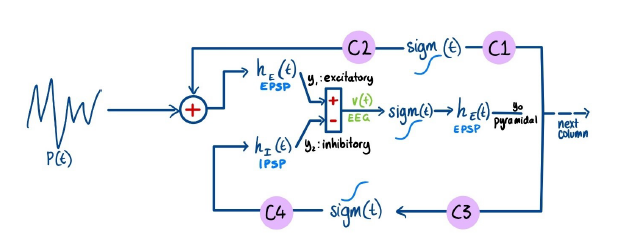

120050
(120050, 8, 100)


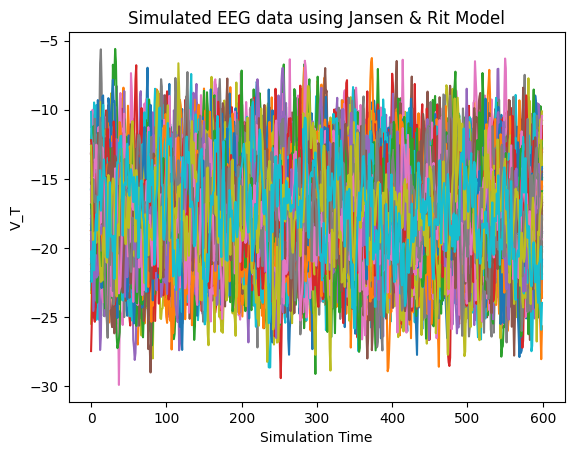

In [101]:
# x3 is a vector of size num_nodes by 1
def calculate_zi(x3):
    return np.dot(SC, x3) # output num_nodes x 1

# System of Equations ########################################################  

# Expanded Jansen & Rit Model 
def system_of_equations(x, alpha, beta, r_0, r_1, r_2, A, B, a, b, C, C1, C2, C3, C4):
    x0, y0, x1, y1, x2, y2, x3, y3 = x

    # Noise  - uncorrelated Gaussian-distributed noise with mean 2 and standard deviation 2
    noise = np.random.normal(2,2,num_nodes) # produces a num_nodes x 1 vector 

    dx0dt = y0
    dy0dt = A * a * (sigmoid(C2 * x1 - C4 * x2 + C * alpha * calculate_zi(x3), r_0)) - 2 * a * y0 - a**2 * x0
    dx1dt = y1
    dy1dt = A * a * (noise + sigmoid(C1 * x0 - C * beta * x2, r_1)) - 2 * a * y1 - a**2 * x1
    dx2dt = y2
    dy2dt = B * b * sigmoid(C3 * x0, r_2) - 2 * b * y2 - b**2 * x2
    dx3dt = y3
    dy3dt = A * ad * (sigmoid(C2 * x1 - C4 * x2 + C * alpha * calculate_zi(x3), r_0)) - 2 * ad * y3 - ad**2 * x3

    return [dx0dt, dy0dt, dx1dt, dy1dt, dx2dt, dy2dt, dx3dt, dy3dt] # num_nodes x 8 matrix output 


# Simulation parameters
dt = 0.005  # Step size
euler_length = 50  # Simulation duration for stabilizing (with Euler method)
sim_length = 600 # Simulation time points (to plot)

# Initial conditions
initial_conditions = np.ones((8, num_nodes)) * 0.1

# Array to store results
sol = np.zeros((int(euler_length + sim_length/ dt), 8, num_nodes))
sol[0] = initial_conditions

# Run simulation using Euler method
print(int(euler_length + sim_length/ dt))
for i in range(1, int(euler_length + sim_length/ dt)):
    sol[i] = sol[i - 1] + dt * np.array(system_of_equations(sol[i - 1], alpha, beta, r_0, r_1, r_2, A, B, a, b, C, C1, C2, C3, C4))

# Plot EEG Results #################################################################
final_sol = sol[-sim_length:] # take the last sim_length time points, so sim_length * 8 * 100

final_x1 = final_sol[:, 2]
final_x2 = final_sol[:, 4]
final_x3 = final_sol[:, 6]

# Calculate V_T for each simulation point
V_T = np.zeros((sim_length, num_nodes))
for sim_point in range(sim_length):
    # Must produce (100, 1) vector
    V_T[sim_point] = C2 * final_x1[sim_point] - C4 * final_x2[sim_point] + C * alpha * calculate_zi(final_x3[sim_point])

# Plot V_T for each node
for node in range(num_nodes):
    plt.plot(V_T[:, node], label=f'Node {node+1}')

plt.xlabel('Simulation Time')
plt.ylabel('V_T')
plt.title('Simulated EEG data using Jansen & Rit Model')

# Add legend to the right of the plot
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


(600, 100)
120050


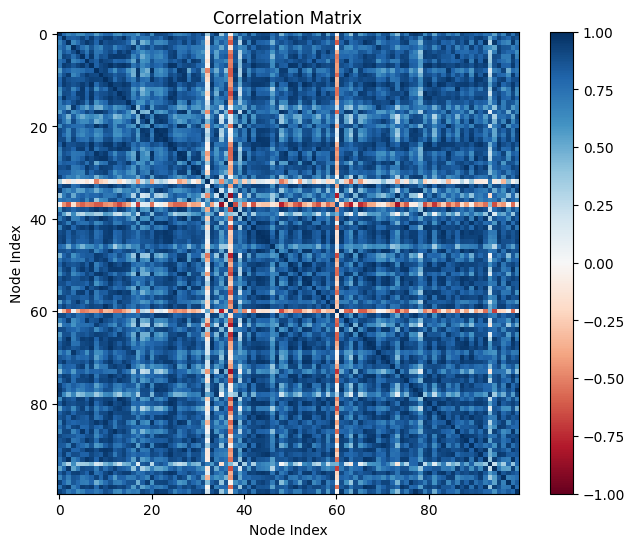

In [116]:
# Balloon-Windkessel Hemodynamic Model #####################################################
# Time Constants
tau_s = 0.65 # Signal decay
tau_f = 0.41 # blood inflow
tau_v = 0.98 # blood volume
tau_q = 0.98 # deoxyhemoglobin content

k = 0.32 # stiffness constant, represents resistance in veins to blood flow
E_0 = 0.4 # resting oxygen extraction rate

# Chosen Constants 
k1 = 2.77
k2 = 0.2
k3 = 0.5

V_0 = 0.03 # fraction of deoxygenated blood in resting state 

# Calculate firing rates, V_T is EEG like response, r_0 is the sigmoid slope
firing_rates = sigmoid(V_T, r_0) # sim_length x num_nodes

scaling = 1000000

# ODEs for Balloon Windkessel Model
def balloon_windkessel_ode(state, t):
    # s: vasodilatory response
    # f: blood inflow
    # v: blood volume
    # q: deoxyhemoglobin content
    s, f, v, q = state
    
    # NOTE - multiplying firing rate by a large constant
    ds_dt  = scaling * firing_rates[t] - s / tau_s - (f - 1) / tau_f
    df_dt = s
    dv_dt = (f - v**(1/k)) / tau_v
    dq_dt = ((f * (1 - (1 - E_0)**(1 / f))) / E_0 - (q * v**(1/k)) / v) / tau_q
    
    return [ds_dt, df_dt, dv_dt, dq_dt]

# Initial conditions
initial_conditions = np.array([[0.1, 1, 1, 1]] * num_nodes).T

print(firing_rates.shape)
print(int(euler_length + sim_length/ dt))
# Array to store results
BOLD_vars = np.zeros((int(euler_length + sim_length/ dt), 4, num_nodes))
BOLD_vars[0] = initial_conditions

# Run simulation using Euler method
for i in range(1, sim_length): 
    # NOTE - useing sim_length instead of int(euler_length + sim_length/ dt) because of size of firing rates
    BOLD_vars[i] = BOLD_vars[i - 1] + dt * np.array(balloon_windkessel_ode(BOLD_vars[i - 1], i))

# Initialize BOLD array
BOLD_array = np.zeros((sim_length, num_nodes))

# Generate BOLD array
for t in range(sim_length):
    q = BOLD_vars[t, 3, :]
    v = BOLD_vars[t, 2, :]
    BOLD_array[t, :] = V_0 * (k1 * (1 - q) + k2 * (1 - (q/v)) + k3 * (1 - v))

# Now have a 600x100 BOLD array stored in BOLD_array
# Calculate the SC from the BOLD signal


SC_matrix = np.corrcoef(BOLD_array.T)

plt.figure(figsize=(8, 6))
plt.imshow(SC_matrix, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Correlation Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()